In [1]:
import clustersight as cs

In [2]:
import torch
import numpy as np
import pandas as pd

In [3]:
embeddings = torch.load('bilstm_embeddings.pt').numpy()
labels = torch.load('all_clono_labels.pt').numpy()

In [4]:
# un-one-hot encode
labels = np.argmax(labels, axis=1)

In [5]:
# create df
embeddings_cols = [f'component_{i}' for i in range(20)]
embeddings_df = pd.DataFrame(embeddings, columns=embeddings_cols)
labels_df = pd.DataFrame(labels, columns=['tcr_spec'])
df = pd.concat([embeddings_df, labels_df], axis=1)
print('Before de-dupe: ', len(df), ' entries')
print('flu: ', len(df[df['tcr_spec'] == 14]), ' entries')
df = df.drop_duplicates().reset_index(drop=True)
print('flu: ', len(df[df['tcr_spec'] == 14]), ' entries')

Before de-dupe:  40500  entries
flu:  1263  entries
flu:  508  entries


In [6]:
df['is_flu'] = df['tcr_spec'] == 14
flu_df = df[df['is_flu']].reset_index(drop=True)
# df.to_csv('embeddings_labels_df.csv', index=False)

In [7]:
cs.create_lasso(flu_df, mode='explainer', label_col='is_flu', exclude_cols=['tcr_spec'], dtreeviz_plot=True, plot_name='Flu Epitope Clustering')

    'data': [{'marker': {'color': '#EF553B'},
              'mode': 'markers',
 …

In [8]:
def assign_cluster(row):
    if row['is_flu']:
        if row['component_18'] <= -0.006:
            return 'flu_cluster1'
        elif row['component_18'] > 0.6:
            return 'flu_cluster3'
        else:
            return 'flu_cluster2'
    else:
        return 'not_flu'

# Apply the function to each row in the dataframe
flu_df['cluster'] = flu_df.apply(assign_cluster, axis=1)

In [9]:
def downsample_nonflu(df, frac=0.1):
    # this makes the clustering faster
    
    false_rows = df[~df['is_flu']]

    # Downsample the selected rows to include 10% of the rows
    downsampled_df = false_rows.sample(frac=frac)

    # Combine the downsampled rows with the original rows where 'is_flu' is True
    return pd.concat([df[df['is_flu']], downsampled_df])

df = downsample_nonflu(df, 0.25)

In [11]:
cs.create_lasso(flu_df, mode='explainer', label_col='cluster', exclude_cols=['tcr_spec'], dtreeviz_plot=True, plot_name='Flu Epitope Clustering')

    'data': [{'marker': {'color': '#636EFA'},
              'mode': 'markers',
 …

# Inspect what factors of flu/nonflu epitopes differ

## Based on means

In [24]:
df['cluster'] = df.apply(assign_cluster, axis=1)

nonflu_means = df[df['cluster'] == 'not_flu'].select_dtypes(include='number').mean(axis=0)
cluster1_means_delta = df[df['cluster'] == 'flu_cluster1'].select_dtypes(include='number').mean(axis=0) - nonflu_means
cluster2_means_delta = df[df['cluster'] == 'flu_cluster2'].select_dtypes(include='number').mean(axis=0) - nonflu_means
cluster3_means_delta = df[df['cluster'] == 'flu_cluster3'].select_dtypes(include='number').mean(axis=0) - nonflu_means

In [25]:
means = pd.concat([cluster1_means_delta, cluster2_means_delta, cluster3_means_delta], 
                  axis=1)
means.columns = ['c1', 'c2', 'c3']

In [26]:
means.drop('tcr_spec', axis=0, inplace=True)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unpivot the dataframe from wide to long format
means_melted = means.reset_index().melt(id_vars='index', var_name='cluster', value_name='Mean Difference')
means_melted.head()

,index,cluster,Mean Difference
0,component_0,c1,0.037908
1,component_1,c1,0.014956
2,component_2,c1,0.326274
3,component_3,c1,-0.315598
4,component_4,c1,-0.724833


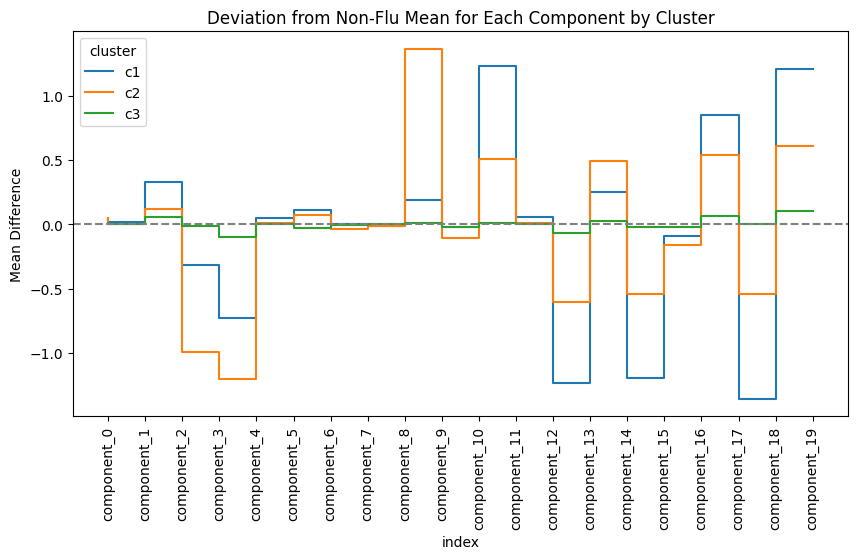

In [29]:
# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=means_melted, x='index', y='Mean Difference', hue='cluster', drawstyle='steps-pre')
plt.axhline(0, color='gray', linestyle='--')  # Add a line at y=0 for the baseline
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Deviation from Non-Flu Mean for Each Component by Cluster')
plt.show()

# Exploring w/ violin plots, accounting for our three clusters 

In [ ]:
c1_delta = df[df['cluster'] == 'flu_cluster1'].select_dtypes(include='number') - nonflu_means
c2_delta = df[df['cluster'] == 'flu_cluster2'].select_dtypes(include='number') - nonflu_means
c3_delta = df[df['cluster'] == 'flu_cluster3'].select_dtypes(include='number') - nonflu_means

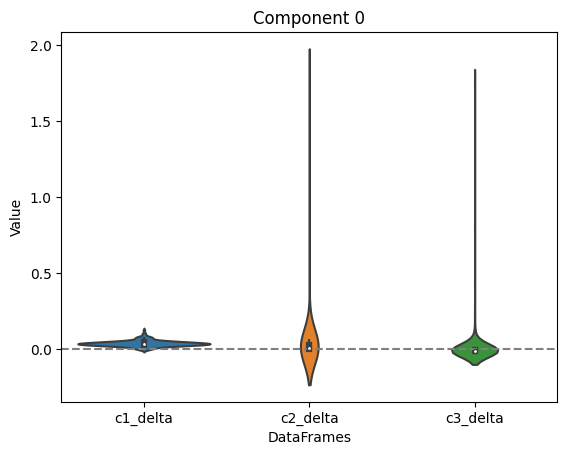

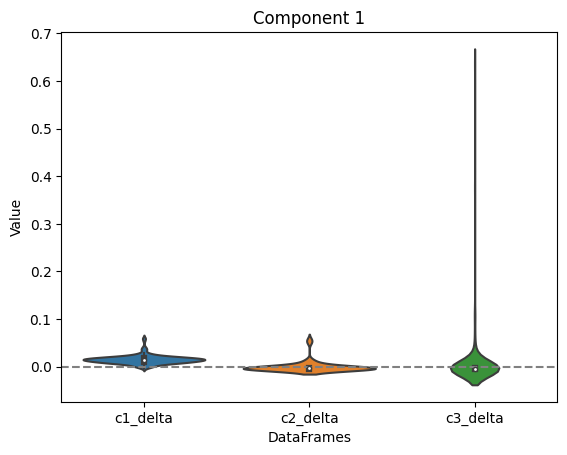

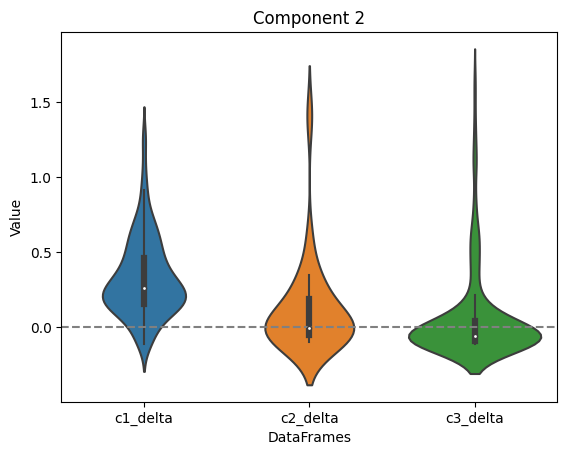

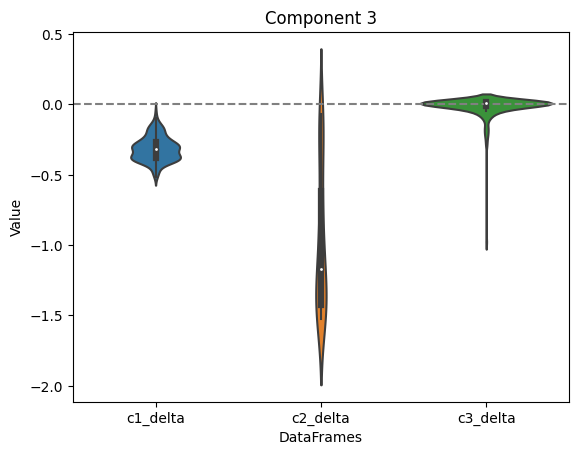

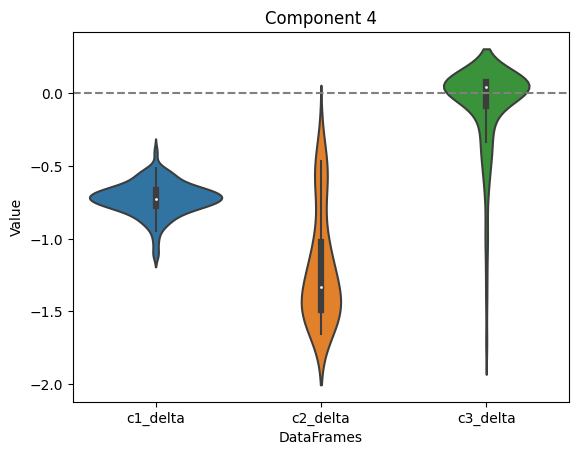

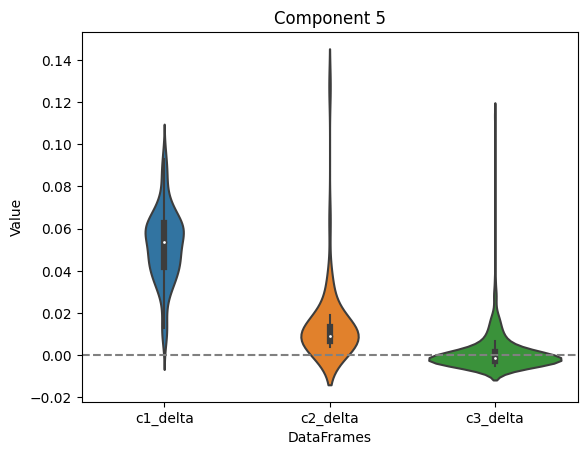

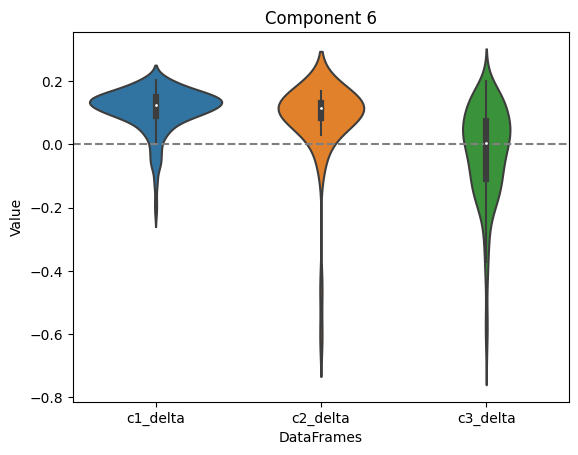

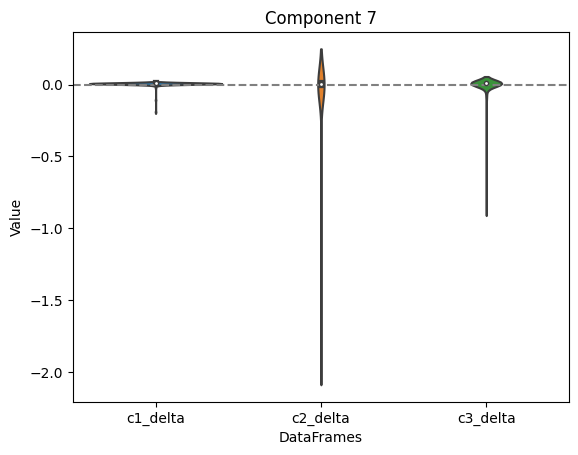

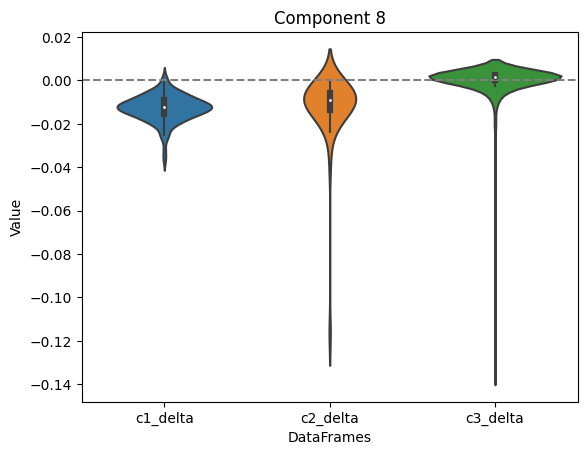

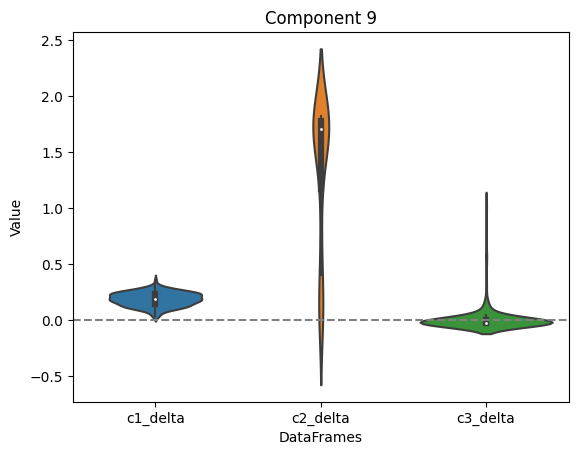

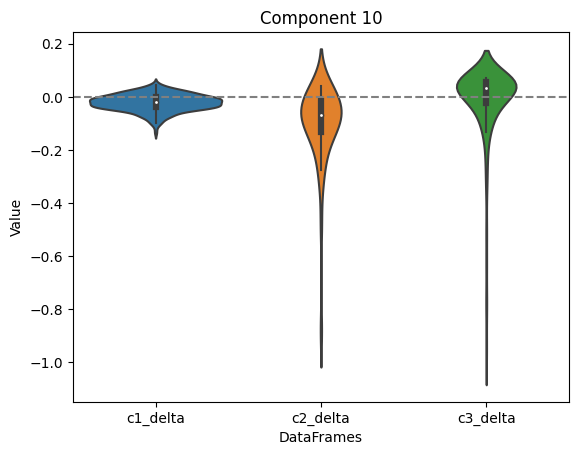

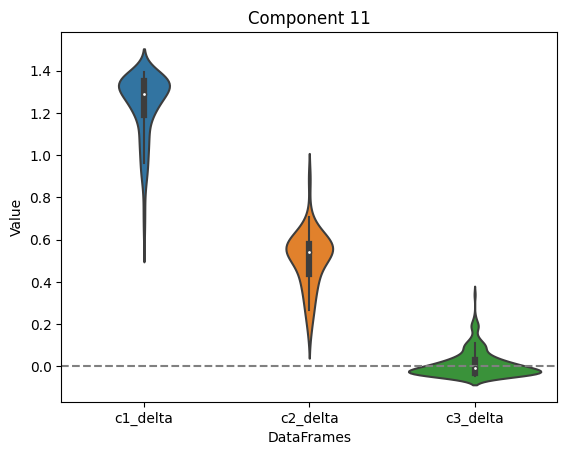

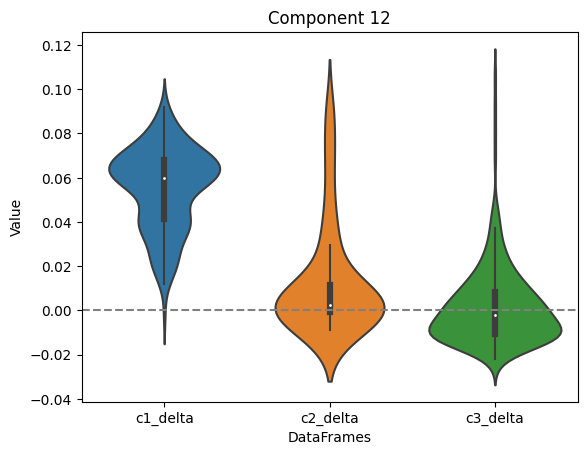

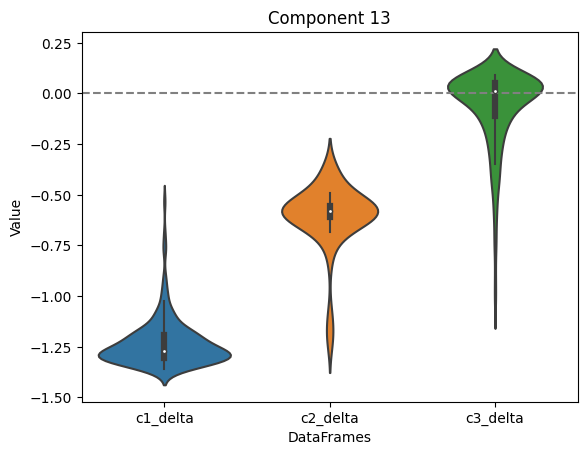

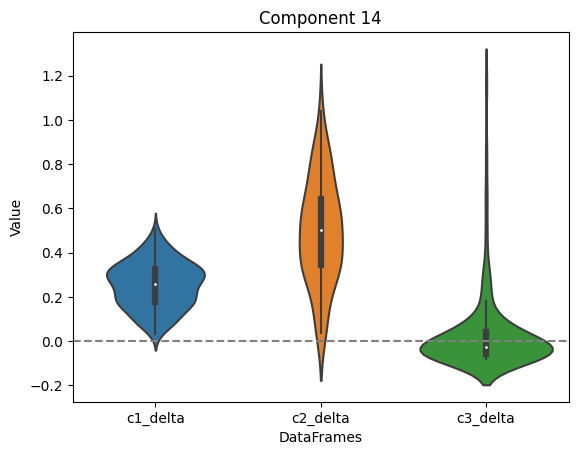

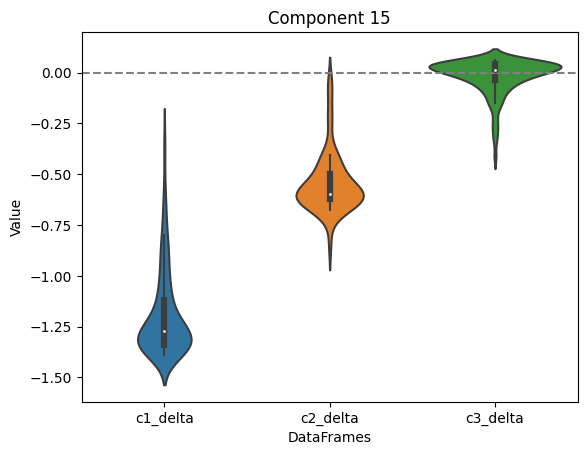

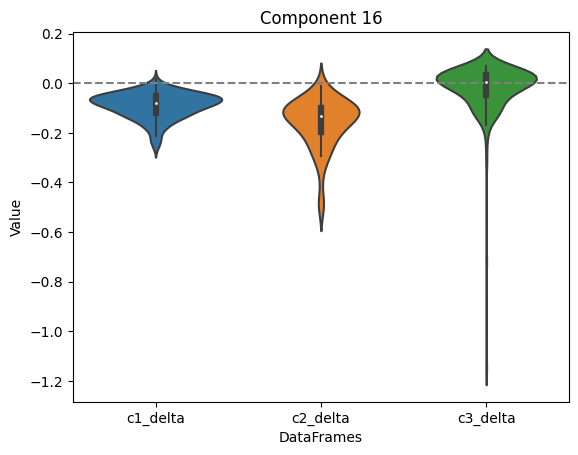

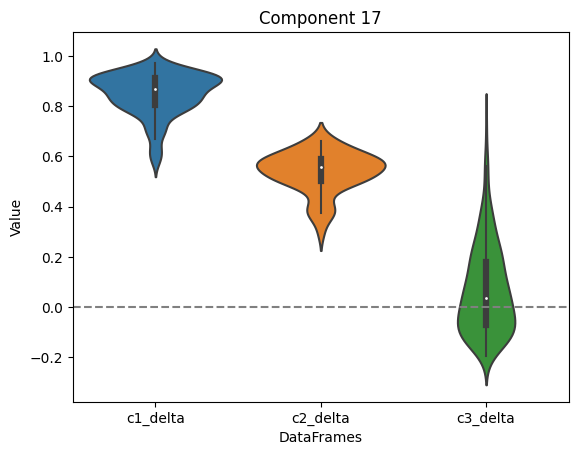

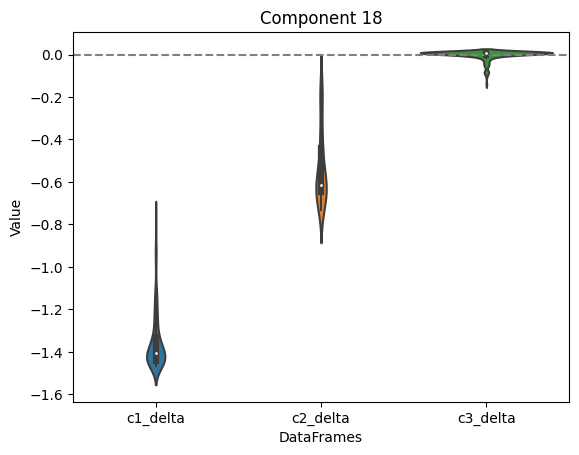

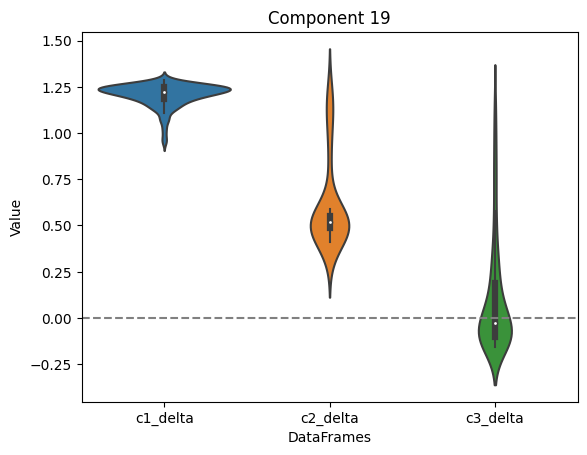

In [33]:
# Concatenate the three DataFrames vertically
combined_df = pd.concat([c1_delta, c2_delta, c3_delta], ignore_index=True)

# Create a new column to indicate the source DataFrame
combined_df['Source'] = ['c1_delta'] * len(c1_delta) + ['c2_delta'] * len(c2_delta) + ['c3_delta'] * len(c3_delta)

for i in range(0, 20):
    # Plot the violin plot
    sns.violinplot(data=combined_df, x='Source', y=f'component_{i}')

    # Set the plot title and labels
    plt.title(f'Component {i}')
    plt.xlabel('DataFrames')
    plt.ylabel('Value')
    plt.axhline(0, color='gray', linestyle='--')

    # Show the plot
    plt.show()

[Text(0.15501071100042407, 0.9852941176470589, 'component_18 <= 0.233\ngini = 0.106\nsamples = 9083\nvalue = [8575, 508]\nclass = not flu'),
 Text(0.0789428522395744, 0.9558823529411765, 'component_4 <= 0.482\ngini = 0.142\nsamples = 261\nvalue = [20, 241]\nclass = is flu'),
 Text(0.07162061666952692, 0.9264705882352942, 'component_17 <= -0.13\ngini = 0.111\nsamples = 254\nvalue = [15, 239]\nclass = is flu'),
 Text(0.06795949888450317, 0.8970588235294118, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = not flu'),
 Text(0.07528173445455065, 0.8970588235294118, 'component_3 <= 0.886\ngini = 0.105\nsamples = 253\nvalue = [14, 239]\nclass = is flu'),
 Text(0.07162061666952692, 0.8676470588235294, 'component_0 <= -0.848\ngini = 0.098\nsamples = 252\nvalue = [13, 239]\nclass = is flu'),
 Text(0.05537440649848407, 0.8382352941176471, 'component_16 <= 0.638\ngini = 0.091\nsamples = 250\nvalue = [12, 238]\nclass = is flu'),
 Text(0.0338653395114696, 0.8088235294117647, 'component_5 <= -0.924\

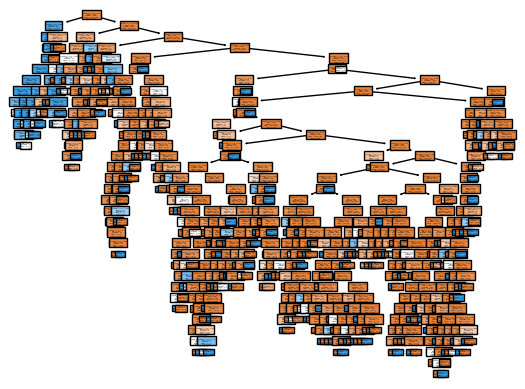

In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

x_cols = [f'component_{i}' for i in range(20)]
X = df[x_cols]
y = df['is_flu']

# Create an instance of the DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Fit the classifier on the data
clf.fit(X, y)

# Print the learned decision tree criteria
tree_criteria = clf.tree_.feature
x = plot_tree(clf,
           feature_names = x_cols,
           class_names=['not flu', 'is flu'],
           filled = True)
x

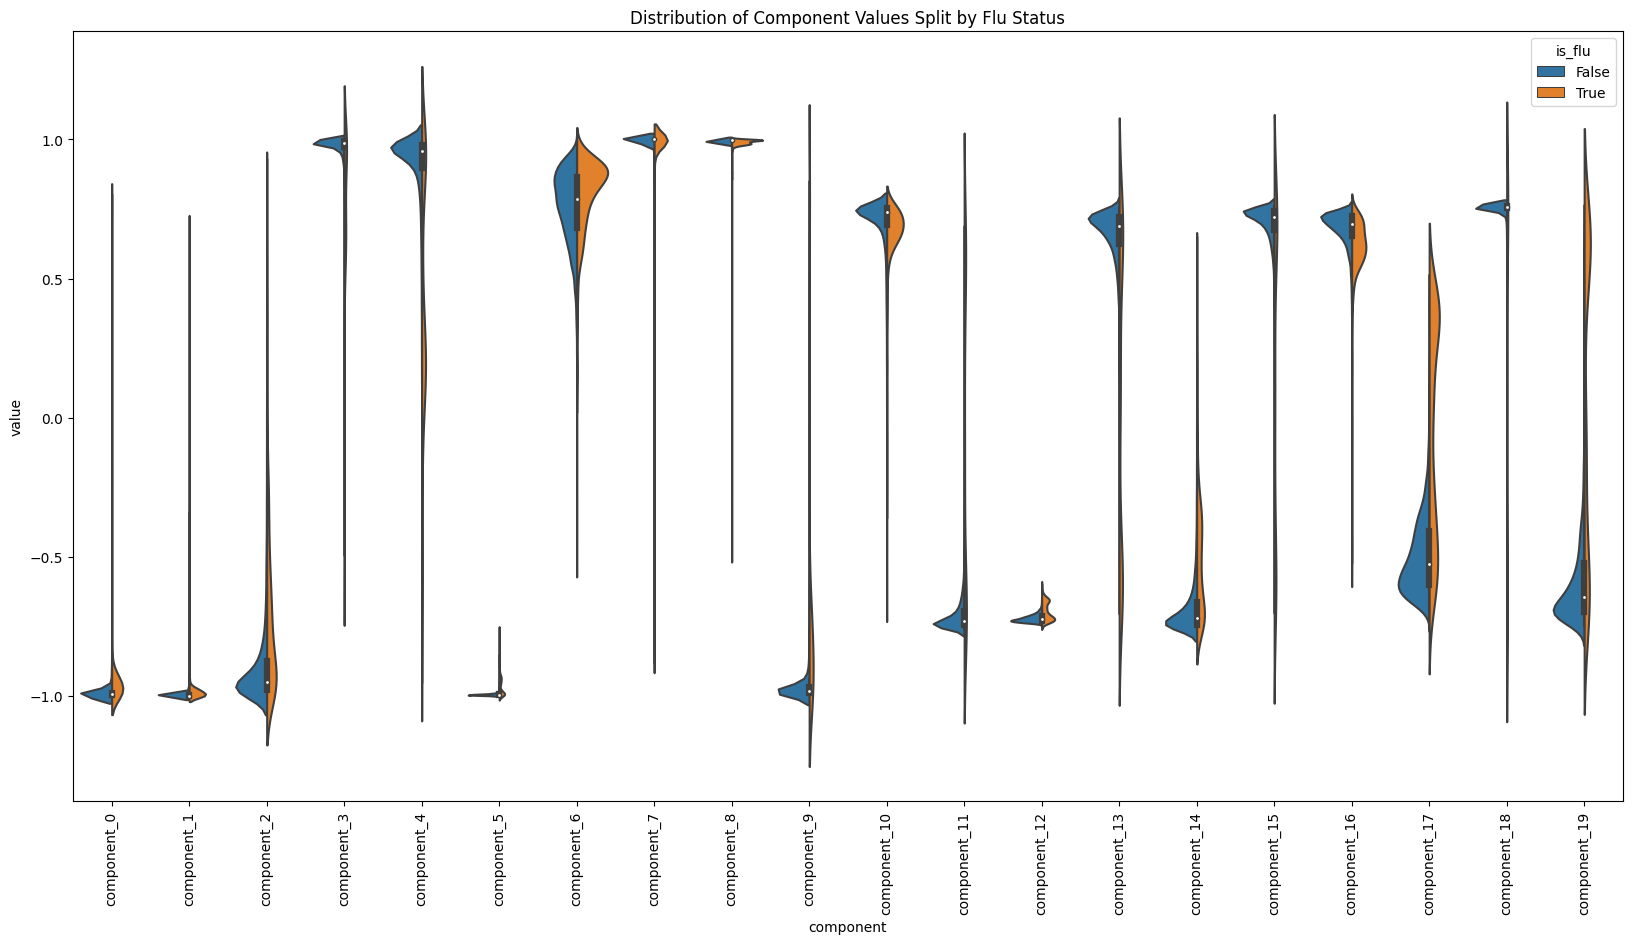

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df and has a column named 'is_flu'
x_cols = [f'component_{i}' for i in range(20)]
df_melted = df.melt(id_vars='is_flu', value_vars=x_cols, var_name='component', value_name='value')

plt.figure(figsize=(20, 10))
sns.violinplot(data=df_melted, x='component', y='value', hue='is_flu', split=True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Distribution of Component Values Split by Flu Status')
plt.show()

## Generate an informal classifier by inspecting this plot 

In [35]:
# test out based on this graph
def visual_classify(row, num=1):
    conditions = [
        row['component_4'] < -0.15,
        row['component_11'] > -0.25,
        row['component_13'] < -0.4,
        row['component_19'] > -0.35
    ]
    return sum(conditions) >= num


### and confusion matrices based on varying how strict we are

In [36]:
from sklearn.metrics import confusion_matrix

# Assuming 'test_classify' contains the predicted classifications
for i in range(1, 5):
    def cls(row):
        return visual_classify(row, num=i)

    # Apply the function to each row in the dataframe to get predicted labels
    df['test_classify'] = df.apply(cls, axis=1)

    # Get the true labels from the original DataFrame
    true_labels = df['is_flu']

    # Get the predicted labels from 'test_classify'
    predicted_labels = df['test_classify']

    # Define the class names
    class_names = [0, 1]

    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

    # Label the confusion matrix rows and columns
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Print the confusion matrix
    print(f'Confusion Matrix {i}:')
    print(cm_df)

Confusion Matrix 1:
      0    1
0  7776  799
1   196  312
Confusion Matrix 2:
      0    1
0  8530   45
1   253  255
Confusion Matrix 3:
      0    1
0  8560   15
1   283  225
Confusion Matrix 4:
      0  1
0  8575  0
1   505  3


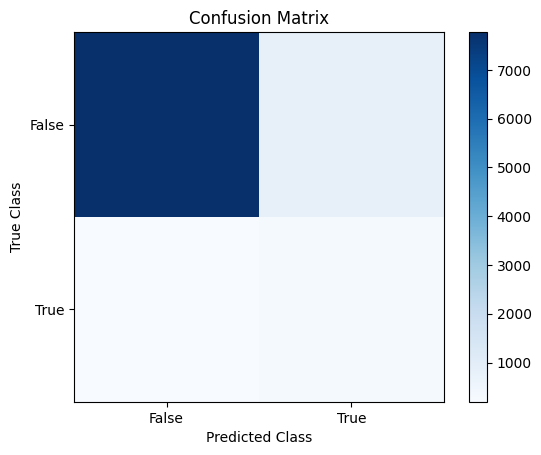

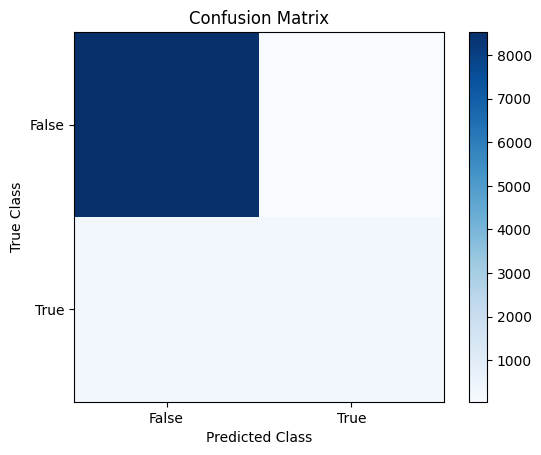

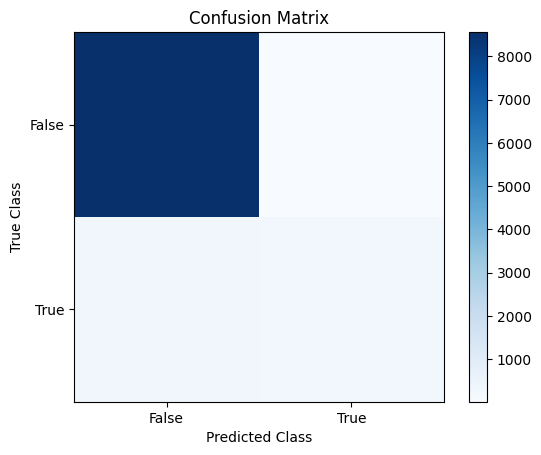

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming 'test_classify' contains the predicted classifications

# Get the true labels from the original DataFrame
true_labels = df['is_flu']

# Define the class names
class_names = ['False', 'True']

for i in range(1, 4):
    def cls(row):
        return visual_classify(row, num=i)
    df['test_classify'] = df.apply(cls, axis=1)    
    # Get the predicted labels from 'test_classify'
    predicted_labels = df['test_classify']

    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Set labels and ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Display the plot
    plt.show()
